In [40]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Prevent TF eating all the GPU memory and crashing the machine

In [41]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [42]:
import pandas as pd
from pathlib import Path

course_data_dir = Path("src/data/course")
data_dir = Path("src/data")

df = pd.read_csv(
        course_data_dir / "book_sales.csv",
        index_col='Date',
        parse_dates=['Date'],
    ).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


In [43]:
import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


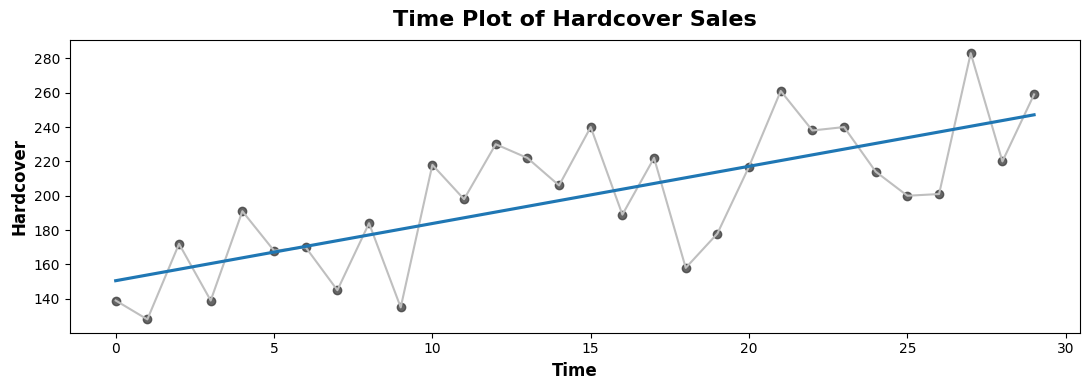

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [45]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


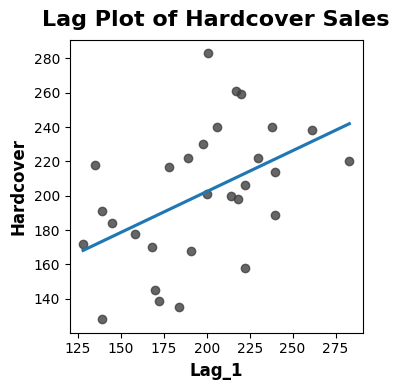

In [46]:
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

In [47]:
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Load Tunnel Traffic dataset
tunnel = pd.read_csv(course_data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [48]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [49]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

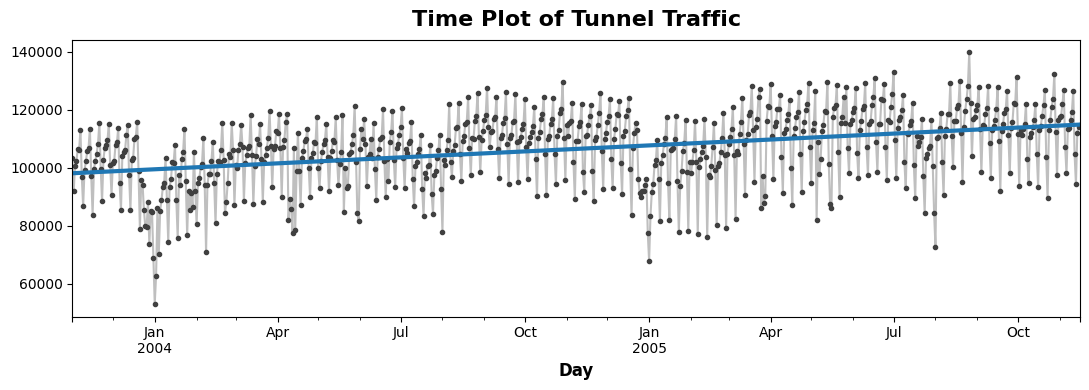

In [50]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

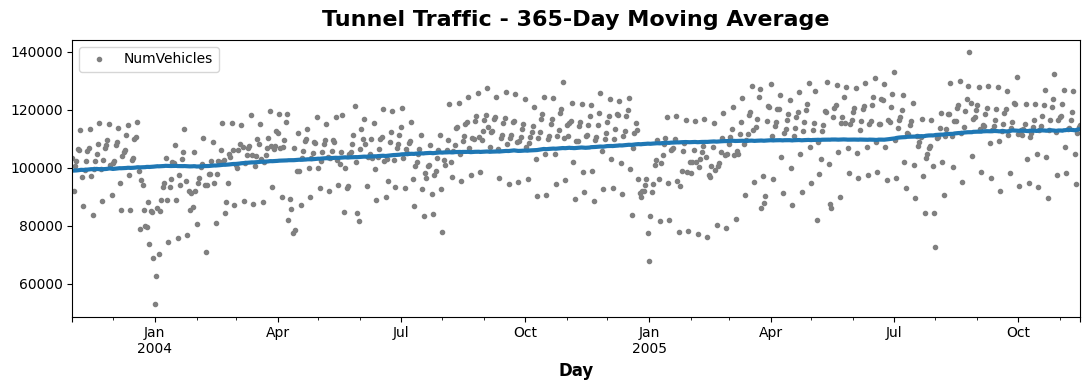

In [51]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [52]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [53]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

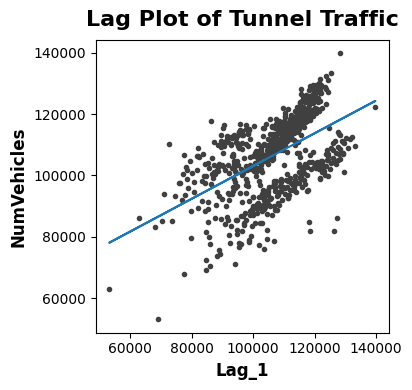

In [54]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

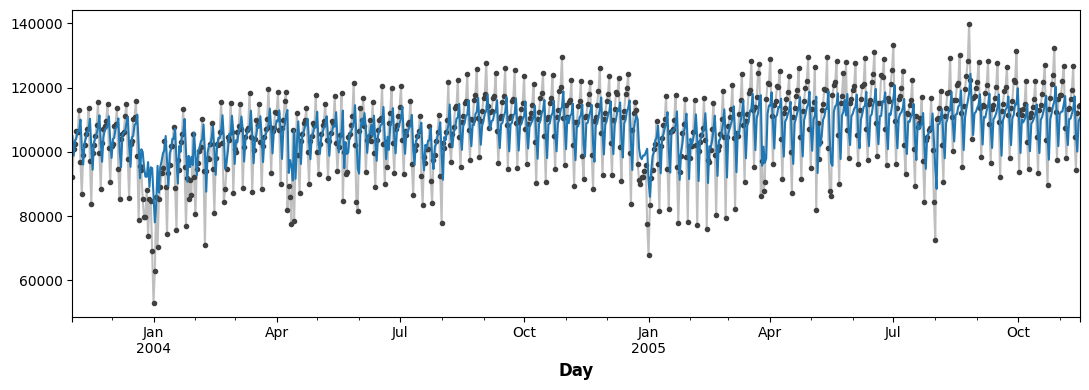

In [55]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [56]:
book_sales = pd.read_csv(
    course_data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
# book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])
book_sales.head()

,Hardcover,Time,Lag_1
Date,,,
2000-04-01,139,0,NaN
2000-04-02,128,1,139.0
2000-04-03,172,2,128.0
2000-04-04,139,3,172.0
2000-04-05,191,4,139.0


In [57]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    data_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
store_sales[0:50]

id  sales  onpromotion
date       store_nbr family                                            
2013-01-01 1         AUTOMOTIVE                   0    0.0            0
                     BABY CARE                    1    0.0            0
                     BEAUTY                       2    0.0            0
                     BEVERAGES                    3    0.0            0
                     BOOKS                        4    0.0            0
                     BREAD/BAKERY                 5    0.0            0
                     CELEBRATION                  6    0.0            0
                     CLEANING                     7    0.0            0
                     DAIRY                        8    0.0            0
                     DELI                         9    0.0            0
                     EGGS                        10    0.0            0
                     FROZEN FOODS                11    0.0            0
                     GROCERY I                   12    0.0            0
                     GROCERY II                  13    0.0            0
                     HARDWARE                    14    0.0            0
                     HOME AND KITCHEN I          15    0.0            0
                     HOME AND KITCHEN II         16    0.0            0
                     HOME APPLIANCES             17    0.0            0
                     HOME CARE                   18    0.0            0
                     LADIESWEAR                  19    0.0            0
                     LAWN AND GARDEN             20    0.0            0
                     LINGERIE                    21    0.0            0
                     LIQUOR,WINE,BEER            22    0.0            0
                     MAGAZINES                   23    0.0            0
                     MEATS                       24    0.0            0
                     PERSONAL CARE               25    0.0            0
                     PET SUPPLIES                26    0.0            0
                     PLAYERS AND ELECTRONICS     27    0.0            0
                     POULTRY                     28    0.0            0
                     PREPARED FOODS              29    0.0            0
                     PRODUCE                     30    0.0            0
                     SCHOOL AND OFFICE SUPPLIES  31    0.0            0
                     SEAFOOD                     32    0.0            0
           10        AUTOMOTIVE                  33    0.0            0
                     BABY CARE                   34    0.0            0
                     BEAUTY                      35    0.0            0
                     BEVERAGES                   36    0.0            0
                     BOOKS                       37    0.0            0
                     BREAD/BAKERY                38    0.0            0
                     CELEBRATION                 39    0.0            0
                     CLEANING                    40    0.0            0
                     DAIRY                       41    0.0            0
                     DELI                        42    0.0            0
                     EGGS                        43    0.0            0
                     FROZEN FOODS                44    0.0            0
                     GROCERY I                   45    0.0            0
                     GROCERY II                  46    0.0            0
                     HARDWARE                    47    0.0            0
                     HOME AND KITCHEN I          48    0.0            0
                     HOME AND KITCHEN II         49    0.0            0

In [58]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

In [59]:
retail_sales = pd.read_csv(
    course_data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

In [60]:
auto_sales.head()

Month
1992-01-01    26788
1992-02-01    28203
1992-03-01    31684
1992-04-01    32547
1992-05-01    32883
Freq: D, Name: Automobiles, dtype: int64

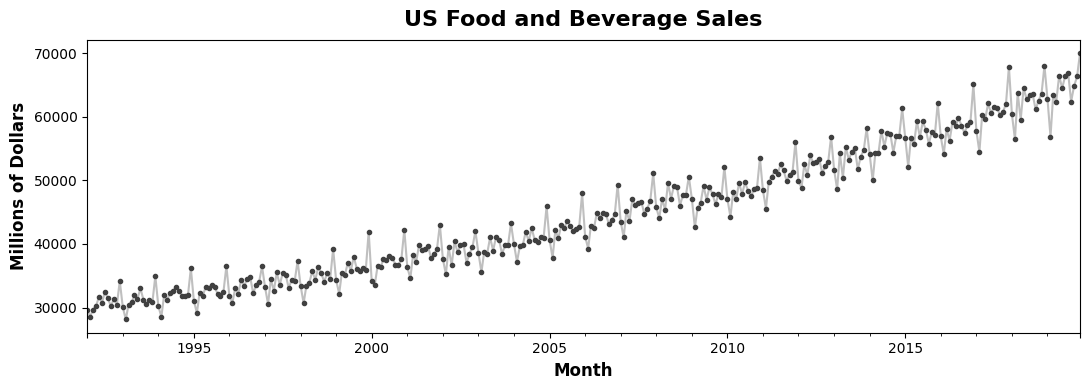

In [61]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

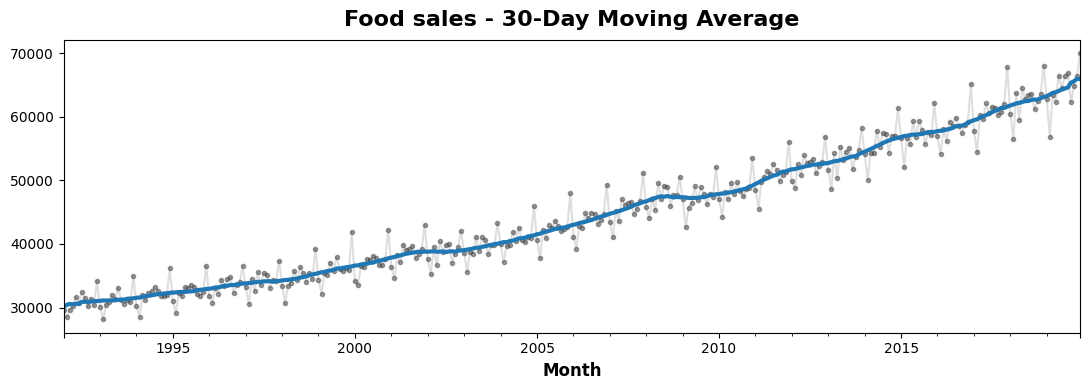

In [62]:
# YOUR CODE HERE: Add methods to `food_sales` to compute a moving
# average with appropriate parameters for trend estimation.
trend = food_sales.rolling(
    window=12,       # 30-day window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3, title="Food sales - 30-Day Moving Average")

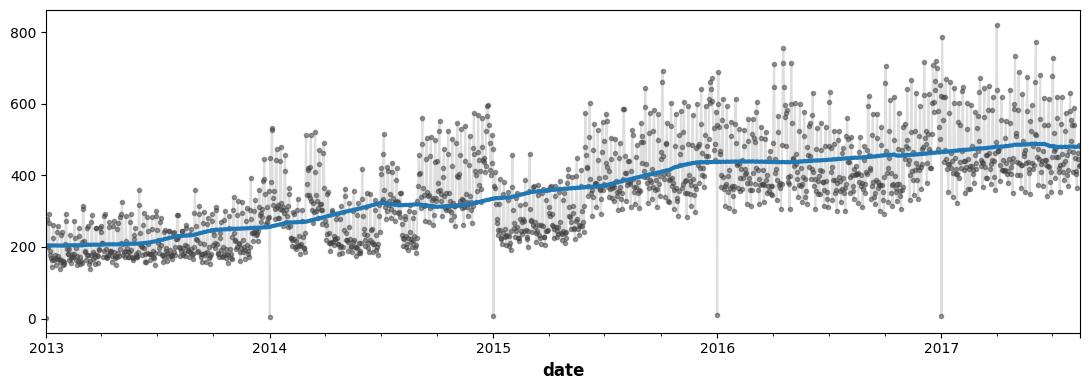

In [63]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [64]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

time = np.arange(len(df.index))  # time dummy

df['time'] = time

X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

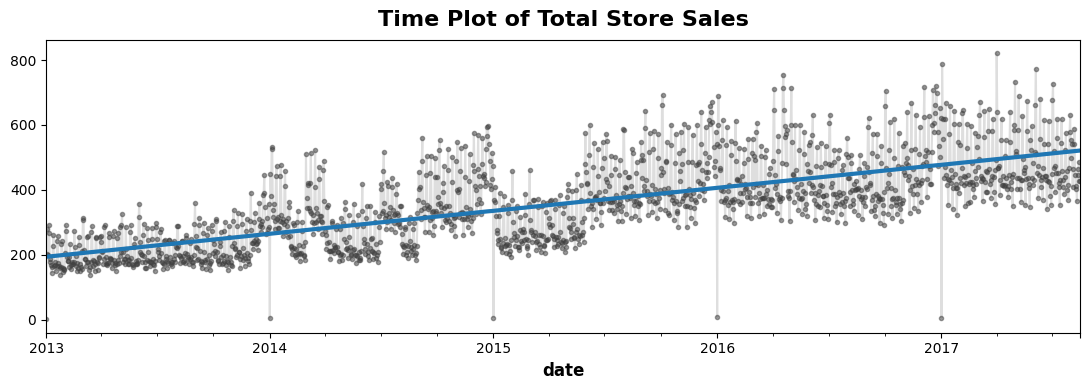

In [65]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [66]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

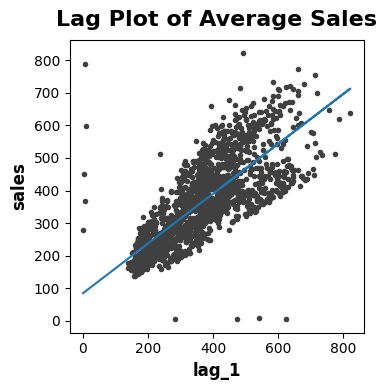

In [67]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [68]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()

dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)
X.head()

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,2.0,4.0,8.0
2013-01-03,3.0,9.0,27.0
2013-01-04,4.0,16.0,64.0
2013-01-05,5.0,25.0,125.0


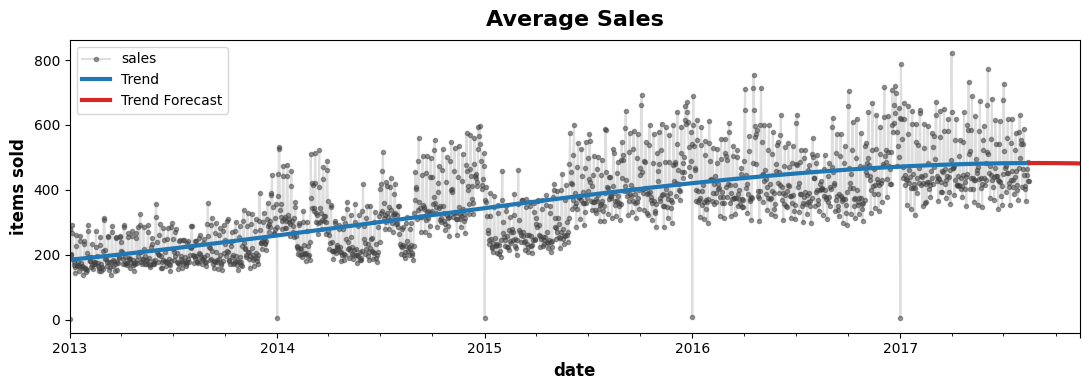

In [69]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.

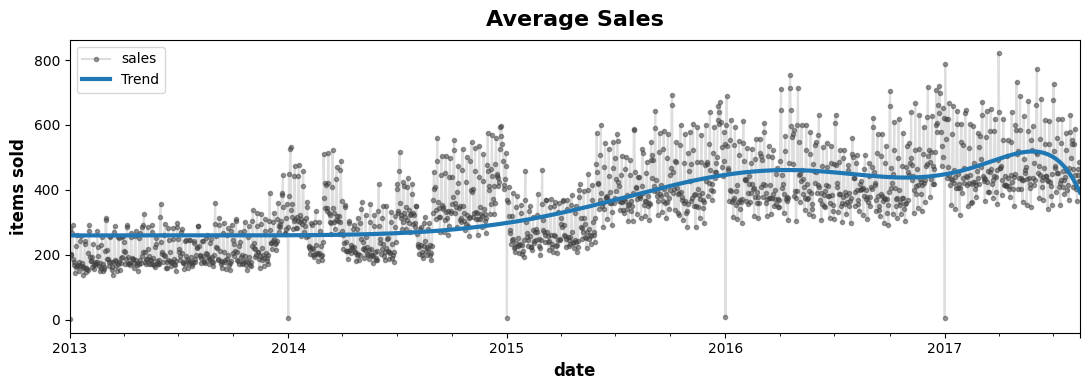

In [70]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

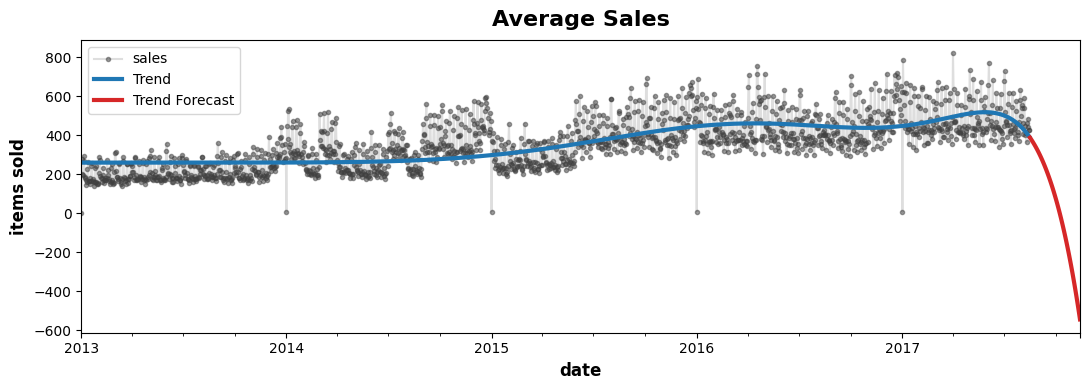

In [71]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();